In [1]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.optimizers import RMSprop, rmsprop
from keras import Sequential
from keras.activations import relu
import urllib.request
import os
import matplotlib.pyplot as plt
import numpy as np
import csv 

Using TensorFlow backend.


In [2]:
max_features = 10000
max_len = 500
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


# 1D CNN  for word_processing

In [3]:
model = Sequential()
model.add(layers.Embedding(max_features,32))
model.add(layers.Conv1D(32,7,activation='relu'))
model.add(layers.MaxPool1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer=RMSprop(lr=1e-4),
loss='binary_crossentropy',
metrics=['acc'])

history = model.fit(x_train, y_train,
epochs=10,
batch_size=128,
validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          7200      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 334,433
Trainable params: 334,433
Non-trainable params: 0
________________________________________________

C:\Users\Gebruiker\miniconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 14s 708us/step - loss: 0.7164 - acc: 0.5184 - val_loss: 0.6886 - val_acc: 0.5514
Epoch 2/10
20000/20000 [==============================] - 14s 710us/step - loss: 0.6776 - acc: 0.6133 - val_loss: 0.6788 - val_acc: 0.5922
Epoch 3/10
20000/20000 [==============================] - 14s 716us/step - loss: 0.6577 - acc: 0.6889 - val_loss: 0.6558 - val_acc: 0.6770
Epoch 4/10
20000/20000 [==============================] - 15s 728us/step - loss: 0.6213 - acc: 0.7470 - val_loss: 0.6064 - val_acc: 0.7410
Epoch 5/10
20000/20000 [==============================] - 15s 757us/step - loss: 0.5487 - acc: 0.7800 - val_loss: 0.5196 - val_acc: 0.7862
Epoch 6/10
20000/20000 [==============================] - 16s 803us/step - loss: 0.4659 - acc: 0.8160 - val_loss: 0.4670 - val_acc: 0.8084
Epoch 7/10
20000/20000 [==============================] - 15s 751us/step - loss: 0.4140 - acc: 0.8358 - val_loss: 0.4

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


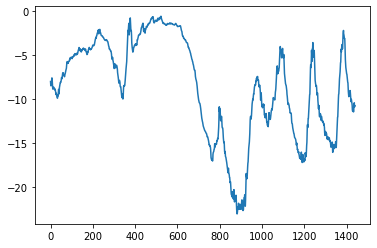

In [4]:
data_dir = 'D:\Downloads\jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

float_data = np.zeros((len(lines), len(header) - 1)) ##CSV FILE ROWS TO NUMPYArray
for i, line in enumerate(lines):
        values = [float(x) for x in line.split(',')[1:]]
        float_data[i, :] = values    
        

temp = float_data[:, 1]  #<1> temperature (in degrees Celsius)
plt.plot(range(1440), temp[:1440])



In [11]:
float_data = np.zeros((len(lines), len(header) - 1)) ##CSV FILE ROWS TO NUMPYArray
for i, line in enumerate(lines):
        values = [float(x) for x in line.split(',')[1:]]
        float_data[i, :] = values    
        
mean = float_data[:200000].mean(axis=0)  ##rescaling all data in numpyArrray
                                         # the same scale(normal distribution) 
                                         # so that NN can easier learn patterns
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std                
    

In [12]:
float_data[0]

array([ 0.90014748, -1.93135845, -1.98211036, -1.86280029,  1.07285236,
       -1.30742164, -1.47375773, -0.79868641, -1.4762674 , -1.47815522,
        2.12375056, -0.72950452, -0.78067973, -0.27613603])

# 1D CRNN temperature forecast

In [13]:
def generator(data, lookback, delay, min_index, max_index,
             shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets ## Data is scooped from Numpy.array 
                               ## and delivered in tuple form (samples,targets)
            

lookback = 1440
step = 3
delay = 144 
batch_size = 128
                ## Creating generators to choose how the data is scooped from
                ## the csv file and kept in our hand
        
train_gen = generator(float_data, ##Numpy array of CSV file
                    lookback=lookback,
                    delay=delay,
                    min_index=0,
                    max_index=200000,
                    shuffle=True,
                    step=step,
                    batch_size=batch_size) # how many samples (batch_size) drawn and
                                           # held in in memmory when feeding into NN

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size



In [16]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer=RMSprop(), loss='mae')
history =  model.fit_generator(generator=train_gen,epochs=6,steps_per_epoch=500,validation_data=val_gen,validation_steps=val_steps)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
gru_5 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
500/500 [==============================] - 119s 238ms/step - loss: 0.3196 - val_loss: 0.0845
Epoch 2/6
500

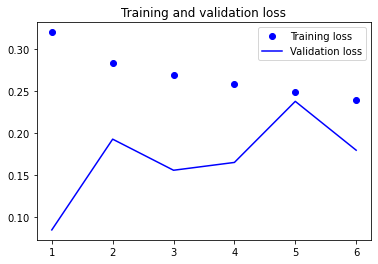

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
samples, label = next(train_gen)

In [ ]:
print(samples[0],label[0])